<font color="#483D8B">
<h1  align="center">Bank's data analysis of direct marketing campaigns of Portuguese banking institution</h1>
<h2 align="center">Using 3 different Models to analysis the data </h2>
<font size=3>
<h4 align = "center"> Ruobing Wang   </h4>
<h5 align = "center"> March 1, 2019  </h5>

---------------

## Overview
Objectives:

- Classification Analysis
-  Scale performance of a logistic regression model with pyspark
-  L-BFGS logistic regression
- Logistic Regression Model with sklearn

- This lab introduces you to two techniques to create a large scale logistic regression that performs  classification.

References:

- https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

- https://stats.stackexchange.com/questions/17436/logistic-regression-with-lbfgs-solver

-------------

## Data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. ." <br/>

- The data can be found at https://www.kaggle.com/rouseguy/bankbalanced/data#bank.csv

- The background information of the data can be found at https://archive.ics.uci.edu/ml/datasets/Bank+Marketing


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [2]:
import pandas as pd
pd.DataFrame(df.take(5), columns = df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [3]:
import pandas as pd
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
#numeric_features
df.toPandas().deposit.value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

In [4]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [5]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

In [6]:
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [7]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)




---------------


## Exploratory Data Analysis

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [8]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

The above code are taken from databricks’ official site and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.

Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.

In [9]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [10]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


As you can see, we now have features column and label column.

Randomly split data into train and test sets, and set seed for reproducibility.

In [11]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


-------------

## Models

#### Logistic Regression Model with Pyspark
- Goal: To predict whether the client will subscribe to a term deposit 

In [12]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

We can obtain the coefficients by using LogisticRegressionModel’s attributes.

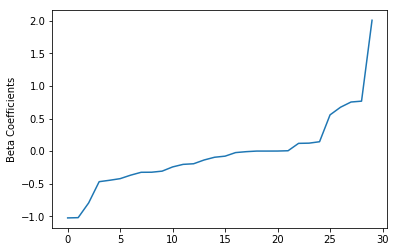

In [13]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.

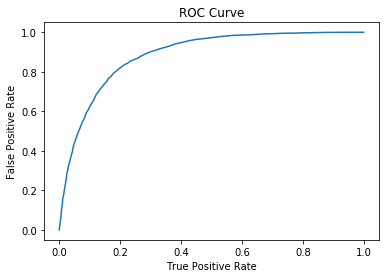

Training set areaUnderROC: 0.8849092421146739


In [14]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

Precision and recall.

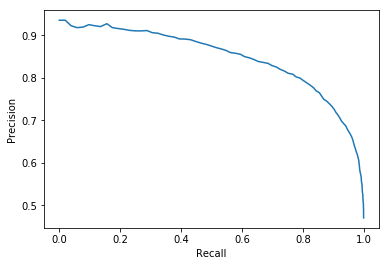

In [15]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Make predictions on the test set.

In [16]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.19871810716723...|       0.0|[0.76829666339830...|
| 40|management|  0.0|[2.20534940465796...|       0.0|[0.90072886169926...|
| 53|management|  0.0|[1.02590348276690...|       0.0|[0.73612093009497...|
| 32|management|  0.0|[1.25795481657702...|       0.0|[0.77867383994058...|
| 54|management|  0.0|[1.33232096924268...|       0.0|[0.79122429116078...|
| 40|management|  0.0|[1.57095096412779...|       0.0|[0.82791913346617...|
| 56|management|  0.0|[3.06095963426752...|       0.0|[0.95525333386804...|
| 50|management|  0.0|[-0.8102603273804...|       1.0|[0.30783502428597...|
| 47|management|  0.0|[0.67024288891379...|       0.0|[0.66155754396054...|
| 44|management|  0.0|[1.29756265761715...|       0.0|[0.78542449653716...|
+---+-------

Evaluate our Logistic Regression model.

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8858324614449619


#### L-BFGS logistic regression

In [18]:
import numpy as np
import scipy as sp
import scipy.optimize
import pandas as pd
import os
data_store = pd.read_csv("bank.csv")
#data_store.dtypes


In [19]:
#then clean the file since it includes null values in the data
#obj_df[obj_df.isnull().any(axis=1)]
#obj_df["deposit"].value_counts()
data_drop_deposit= data_store.drop(['month'],1)
data_deposit_store = data_store['deposit']
data_drop_deposit= data_drop_deposit.drop(['deposit'],1)

s_obj_df_dummy = pd.get_dummies(data_drop_deposit, columns=['job', 'marital', 'education', 'default',  'housing', 'loan', 'contact', 'poutcome'])

s_obj_df_dummy['deposit']=data_deposit_store


In [20]:
#obj_df['deposit'].apply(lambda x: 0 if x=='no' else 1)
s_obj_df_dummy['deposit']=s_obj_df_dummy['deposit'].apply(lambda x: 0 if x=='no' else 1)
s_obj_df_dummy.head()


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,deposit
0,59,2343,5,1042,1,-1,0,1,0,0,...,1,0,0,0,1,0,0,0,1,1
1,56,45,5,1467,1,-1,0,1,0,0,...,1,0,0,0,1,0,0,0,1,1
2,41,1270,5,1389,1,-1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
3,55,2476,5,579,1,-1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,1
4,54,184,5,673,2,-1,0,1,0,0,...,1,0,0,0,1,0,0,0,1,1


In [21]:
array_dummy = np.asarray(s_obj_df_dummy)

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
array_dummy_scaler = scaler.fit_transform(array_dummy)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
vY = array_dummy_scaler[:, -1].astype('float64')
mX = np.asarray(array_dummy_scaler[:, 0:-1]).astype('float64')

In [24]:
intercept = np.ones(mX.shape[0]).reshape(mX.shape[0], 1)
mX = np.concatenate((intercept, mX), axis = 1)
iK = mX.shape[1]
iN = mX.shape[0]
# logistic transformation
def logit(mX, vBeta):
    return((np.exp(np.dot(mX, vBeta))/(1.0 + np.exp(np.dot(mX, vBeta)))))

# stable parametrisation of the cost function
def logLikelihoodLogitStable(vBeta, mX, vY):
    return(-(np.sum(vY*(np.dot(mX, vBeta) -
    np.log((1.0 + np.exp(np.dot(mX, vBeta))))) +
                    (1-vY)*(-np.log((1.0 + np.exp(np.dot(mX, vBeta))))))))
# score function
def likelihoodScore(vBeta, mX, vY):
    return(np.dot(mX.T,
                  (logit(mX, vBeta) - vY)))

#====================================================================
# optimize to get the MLE using the BFGS optimizer (numerical derivatives)
#====================================================================
optimLogitBFGS = sp.optimize.minimize(logLikelihoodLogitStable,
                                    x0 = mX[0],
                                    args = (mX, vY), method = 'BFGS',
                                    options={'gtol': 1e-3, 'disp': True})

print(optimLogitBFGS) # print the results of the optimisation


Optimization terminated successfully.
         Current function value: 4885.558037
         Iterations: 52
         Function evaluations: 2688
         Gradient evaluations: 64
      fun: 4885.5580365733
 hess_inv: array([[ 7.08895030e-01, -4.29783691e-03, -1.60573544e-02, ...,
        -6.83899819e-02, -6.02575218e-02, -6.48303302e-02],
       [-4.29783691e-03,  6.45215311e-02, -2.61298508e-02, ...,
        -6.48249491e-04, -2.89009449e-03, -9.48467370e-04],
       [-1.60573544e-02, -2.61298508e-02,  9.75286160e-01, ...,
        -4.21006587e-03, -3.55810528e-03, -2.39993033e-03],
       ...,
       [-6.83899819e-02, -6.48249491e-04, -4.21006587e-03, ...,
         2.51658035e-01,  2.34851629e-01,  2.35153400e-01],
       [-6.02575218e-02, -2.89009449e-03, -3.55810528e-03, ...,
         2.34851629e-01,  2.46568783e-01,  2.35256772e-01],
       [-6.48303302e-02, -9.48467370e-04, -2.39993033e-03, ...,
         2.35153400e-01,  2.35256772e-01,  2.46428024e-01]])
      jac: array([-2.4414062

In [25]:
#====================================================================
# optimize to get the MLE using the L-BFGS optimizer (analytical derivatives)
#====================================================================
optimLogitLBFGS = sp.optimize.fmin_l_bfgs_b(logLikelihoodLogitStable,
                                  x0 = mX[0],
                                    args = (mX, vY), fprime = likelihoodScore,
                                    pgtol =  1e-3, disp = True)

print(optimLogitLBFGS) # print the results of the optimisation


(array([-5.06052101e-01,  1.84486442e-02,  2.89702001e+00, -2.49270850e-01,
        2.01321870e+01, -7.00123512e+00,  1.85677358e-01,  8.91957142e-01,
        1.81364236e-01, -2.53713356e-01, -3.76263527e-01, -3.07491174e-01,
       -1.56107992e-01,  5.80141702e-01, -3.33093279e-01, -2.07611782e-01,
        7.87369265e-01, -7.69873909e-02, -2.67764534e-03, -3.40981159e-01,
       -1.53618852e-01, -3.19411651e-01, -3.30215977e-02, -3.99723597e-01,
       -1.51835760e-01,  1.55807195e-01, -1.10299938e-01, -1.57347957e-01,
       -3.48704144e-01,  1.58322056e-01, -6.64374157e-01,  6.19710402e-02,
       -5.68023141e-01,  2.46448604e-01,  2.51437294e-01, -1.00393800e+00,
       -6.37042494e-01, -4.88680191e-01,  1.58228761e+00, -9.62617026e-01]), 4885.558127133578, {'grad': array([ 7.21200552e-04, -1.00595576e-03, -4.50876017e-03,  3.60644479e-03,
        7.05012110e-03, -7.19964189e-03,  6.51946834e-03, -1.25876914e-02,
        1.95266709e-03,  4.43742044e-03, -7.23788277e-03,  1.28330046

In [26]:
import numpy as np
from sklearn.metrics import roc_auc_score
prediction = np.dot(optimLogitLBFGS[0],mX.T)
prediction[prediction>=0] = 1
prediction[prediction<0] = 0
roc_auc_score(vY,prediction)


0.8045461029491799

#### Logistic Regression Model with sklearn


In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
array_dummy_scaler
vY = array_dummy_scaler[:, -1].astype('float64')
mX = np.asarray(array_dummy_scaler[:, 0:-1]).astype('float64')
reg = LinearRegression().fit(mX, vY)
#reg = LogisticRegression().fit(mX, vY)
reg_predict= reg.predict(mX)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(vY, reg_predict)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(vY.ravel(), reg_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

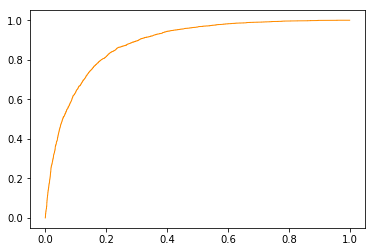

In [29]:
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc[1])

In [30]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(vY,reg_predict)

0.8848059111661961

#### Comparison the results

In [31]:
#performance evaluation of the model 3
import timeit
sk = LinearRegression()
sk_1 = sk.fit(mX, vY)

t = timeit.timeit('sk.fit(mX, vY)',globals=globals(), number=50)

print("the elapsed time of model 1 is: ")
print(t)

the elapsed time of model 1 is: 
0.2065578809999984


In [32]:
#performance evaluation of the model 2
import timeit
sp.optimize.fmin_l_bfgs_b(logLikelihoodLogitStable,
                                  x0 = mX[0],
                                    args = (mX, vY), fprime = likelihoodScore,
                                    pgtol =  1e-3, disp = False)

t = timeit.timeit('sp.optimize.fmin_l_bfgs_b(logLikelihoodLogitStable,x0 = mX[0],args = (mX, vY), fprime = likelihoodScore,pgtol =  1e-3, disp = False)',globals=globals(), number=50)
print("the elapsed time of model 2 is: ")
print(t)

the elapsed time of model 2 is: 
3.140603143


In [33]:
#performance evaluation of the model 1
from pyspark.ml.classification import LogisticRegression
import timeit
comp = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
comp_1 = comp.fit(train)

t = timeit.timeit('comp.fit(train)',globals=globals(), number=50)
print("the elapsed time of model 1 is: ")
print(t)

the elapsed time of model 1 is: 
35.509934227


#### Conclusion

The auc does not have so much differences. And Higher the AUC, the better your model for predicting.

About the time. The LogisticRegression module will cost the longest time and the second one is L-BFGS logistic regression. The shortest time is Logistic Regression Model with sklearn.

The degree of parallelism is:

In [34]:
spark.sparkContext.defaultParallelism

8